<a href="https://www.kaggle.com/code/soumyadipbhat/rare-species-analysis-across-uk?scriptVersionId=143979010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style='background-color:lightgreen;padding:10px;border-radius:15px'>🐇 Rare Species Analysis in UK</span>

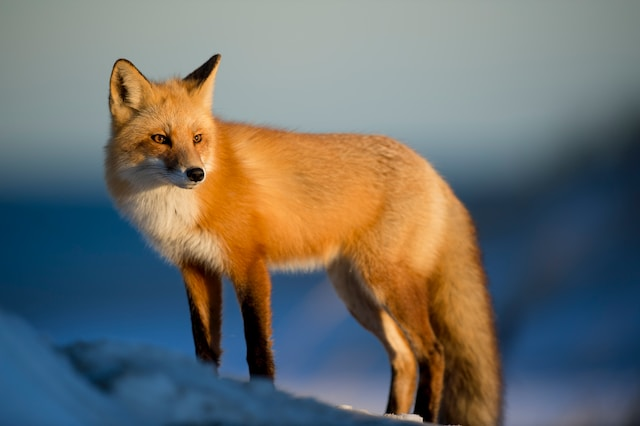

<div style="background-color:#d1faaa;padding:15px;border-radius:20px; width: 80%">
    
<h3>🌐 Resources:</h3>
</br>
Link to the Dataset: <a href='https://www.kaggle.com/datasets/scarfsman/data-resource-national-mammal-atlas-project'>🔗 Link</a>
</br>
<h3>💡 Data Information:</h3>
</br>
Data contains mammal sighting in the UK from the NBN Atlas. The data set includes geo-spacial information on where sightings have occured, as well as biological information on sighted animals in order to filter for specific taxonomies of animals. Data has been modified to removed redundant columns and anonymise the data.

</div>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing all the necessary packages
import pandas as pd
import missingno as msno
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

🌏 Setting Globals settings for this project 👇

In [ ]:
# Settng global properties of the libraries

# pandas
pd.options.display.max_rows = None  # prevent the truncated view of the rows

# matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 600  # High resolution to see small texts in plots easily

# <span style="background-color:lightgreen;padding:10px;border-radius:10px">Loading and quick look at the data</span>

In [ ]:
# Loading the data 
path = '/kaggle/input/data-resource-national-mammal-atlas-project/Data resource - National Mammal Atlas Project.csv'

df = pd.read_csv(path)
df.head().T

# <span style="background-color:lightgreen;padding:10px;border-radius:10px">Quick Information about the data</span>
1. Shape
2. Datatypes
3. Statistical Informations
4. Missing 

In [ ]:
# Function to quickly get some information about the DataFrame
def data_insights(dataframe: pd.DataFrame, nums: int = 10):
    """
    Prints Information about the dataframe (info: shape, dtypes, describe, missing_values)
        Params: 
            dataframe: pd.DataFrame
            nums: int ,Default: 10 -> How many '=' signs required to decorate and to seperate the blocks
        Return:
            Information printed in seperate blocks seperated by new lines
    """
    print(f"{'='* nums}SHAPE OF THE DATAFRAME{'='* nums}\n{dataframe.shape}")
    print(f"\n{'='* nums}DATATYPES OF DIFFERENT COLUMNS{'='* nums}\n{dataframe.dtypes}")
    print(f"\n={'='* nums}STATISTICAL INFORMATION{'='* nums}\n{dataframe.describe()}")
    print(f"\n{'='* nums}CHECK FOR MISSING DATA{'='* nums}\n{dataframe.isna().sum()}")

In [ ]:
data_insights(df, nums = 20)

<span style="background-color:lightgreen;padding:10px;border-radius:10px">Exploratory Data Analysis</span>
<div style="background-color:#d1faaa;padding:15px;border-radius:20px; width: 30%">
<strong>Steps</strong>
    
1. Missing Value visualization
<br>
2. Categorical Values visualization
<br>
4. Plot the coordinate in the maps
<br>    
</div>

In [ ]:
# Visualizing Missing Values
plt.figure(figsize = (10, 4))
df.drop('Vitality', axis = 1).isna().sum().plot(kind = 'barh')
plt.title('Missing Data')
plt.tight_layout()
plt.show()

In [ ]:
# State/Province frequency bar plot
plt.figure(figsize = (10, 4))
country = df['State/Province'].value_counts()
plt.barh(country.index, country.values)
# plt.xticks(rotation = 45)
plt.title('State/Province vs Number of Species')
plt.xlabel('Number of Species')
plt.ylabel('State/Province')
plt.tight_layout()
plt.show()

# <span style='background-color:lightgreen;padding:10px;border-radius:10px'>Visualize Species Info</span>

In [ ]:
# Storing the Common name column in a seperate variable
def plot_species_info(dataframe: pd.DataFrame, thres: int = 1700):
    """
    Visualize via plots that rare species are belong to which places (State/Province)
    Parameter:
        dataframe: Provide the dataframe
        thres: the number of species to consider as threshold (Default value will be 1700 <- Mean value)
    Plots:
        3 plots ;-)
    """
    species = dataframe['Common name'].value_counts()
    species = species.reset_index()
    
    # Most available species
    plt.figure(figsize=(10, 4))
    sns.histplot(species[species['count'] > thres], x = 'Common name', y = 'count')
    plt.xticks(rotation = 90)
    plt.title(f"Most Available Species (count > {thres})")
    plt.tight_layout()
    plt.xticks(fontsize = 4)
    plt.xlabel('')
    plt.ylabel('Number of Species')
    plt.show()
    
    # Least available species
    plt.figure(figsize=(10, 4))
    sns.histplot(species[species['count'] < thres], x = 'Common name', y = 'count')
    plt.xticks(rotation = 90)
    plt.title(f"Least Available Species (count < {thres})")
    plt.tight_layout()
    plt.xticks(fontsize = 4)
    plt.xlabel('')
    plt.ylabel('Number of Species')
    plt.show()
    
    # Rare Species Sheltering Countries
    plt.figure(figsize = (10, 2))
    df1 = dataframe['Common name'].value_counts().reset_index()
    states = df1['Common name'][df1['count'] < thres].values
    dataframe['State/Province'][dataframe['Common name'].isin(states)].value_counts().plot(kind='bar')
    plt.xlabel('States', fontsize = 6)
    plt.xticks(rotation = 0)
    plt.ylabel('Number of Species')
    plt.title(f"Rare Species Sheltering States [threshold = {thres}]")
    plt.show()

Plotting the species info 👇

In [ ]:
plot_species_info(df)

# <span style='background-color:lightgreen;padding:10px;border-radius:10px'>Mapping the Rare Species Accross UK</span>

In [ ]:
df1 = df['Common name'].value_counts().reset_index()
rare_species = df1['Common name'][df1['count'] < 100].values
    
# getting the lattitudes, longitudes and radii of rare species
rare_lats = df['Latitude (WGS84)'][df['Common name'].isin(rare_species)].dropna().values
rare_lons = df['Longitude (WGS84)'][df['Common name'].isin(rare_species)].dropna().values
rare_radii = df['Coordinate uncertainty (m)'][df['Common name'].isin(rare_species)].dropna().values
    
# mean lattitude and longitude to better focus on the region and set the map
mean_lat = np.mean(df['Latitude (WGS84)'].dropna().values)
mean_lon = np.mean(df['Longitude (WGS84)'].dropna().values)
    
m = folium.Map(location = [mean_lat, mean_lon], zoom_start = 6)
    
# add the points with a circle indicating uncertainty of their location.
for lat, lon, radius, species in zip(rare_lats, rare_lons, rare_radii, rare_species):
    popup = folium.Popup(f"Species Name: {species}")
    folium.Circle(
    radius = radius,
    location = [lat, lon],
    fill_color = 'red',
    fill = True,
    popup=popup,
    tooltip='Click to View'
    ).add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.LayerControl().add_to(m)

## <span style='background-color:lightgreen;padding:10px;border-radius:10px'>Mapping</span>
To see the full code look above ☝️

In [ ]:
m

# <span style='background-color:lightgreen;padding:10px;border-radius:10px'>Future Improvements</span>

<div style="background-color:#d1faaa;padding:5px; border-radius: 20px; width: 60%">
    
<ul>
    
   <li>Add pop up on each circles in the map to view</li>
    <ul>
    <li>The name of the species</li>
    <li>The total number of that species accross UK</li>
    <li>The State</li>
    </ul>
<li>Optimize the code of plotting the circle in the map</li>
    <ul>
        <li>Now its a O(3n) algorithm running to plot all the circles in the map</li>
        <li>When number of points starts to grow the CPU usage becomes 100% on kaggle standard notebook.</li>
        <li>Have to come up with a better way to reduce the time complexity</li>
    </ul>
<li>Some more insights:</li>
    <ul>
        <li>Most rare species are from which Phylum, Genus etc.</li>
        <li>and etc. (have not figured it out)</li>
    </ul>
</div>